# Limitations of Gradient-Based Learning

<font color='green'> In this practical session we explore some limitations of learning algorithms based on gradient updates. Our main objectives are the following:
</font>
- <font color='green'>introducing the problem of learning parity functions under a uniform distribution of covariates on the $d$-dimensional boolean hypercube;</font>
- <font color='green'>understanding if the above problem is easy from the statistical perspective;</font>
- <font color='green'>understanding if the above problem is easy from the computational perspective;</font>
- <font color='green'>understanding intuitively why the above problem is not solvable in polynomial time for a large class of algorithms.</font>


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()
plt.rcParams['figure.figsize'] = [9, 6]

## The Problem of Learning Parity Functions

Learning parity functions is a classical example of a problem that is easy to state, yet hard to solve for a large class of machine learning algorithms (specifically, for *statistical query* algorithms; see the bibliographic remarks section). In this practical session, we explore why learning parity functions is difficult for parametric models trained by gradient descent.

To introduce the problem, let $d$ denote the input dimension and let the input space be $\mathcal{X} = \{-1, +1\}^{d}$ &mdash; the $d$-dimensional boolean hypercube. Given any subset $S \subseteq \{0, 1, \dots, d - 1\}$, the *parity function* $f_{S} : \mathcal{X} \to \{-1, +1\}$ is defined by
$$
  f_{S}(x) = \prod_{i \in S} x_{i}, \quad \text{where } x = (x_{0}\, x_{1}\, \dots\, x_{d-1})^{\mathsf{T}} \in \mathcal{X}.
$$
Thus, $f_{S}(x)$ evaluates to $+1$ if the number of negative coordinates of $x$ with indexes in the support set $S$ is even; otherwise $f_{S}(x)$ evaluates to $-1$.

In the following exercise, we are asked to implement functions for generating synthetic data for our experiments. Given natural numbers $n$, $d$ and a support set $S \subset \{0, \dots, d-1\}$, a sample dataset contains a matrix $X \in \{-1, +1\}^{n \times d}$ and a vector $y \in \{-1, +1\}^{n}$. Letting $x_{i}$ denote the $i$-th row of the matrix $X$, the $i$-th data point is $(x_{i}, y_{i}) = (x_{i}, f_{S}(x_{i}))$. We will only consider covariate vectors $x_{i}$ whose elements are sampled independently and uniformly from the set $\{-1, +1\}$. To summarize, the data generating mechanism considered in this practical session can be described as follows:
\begin{align*}
  X &\sim \text{Uniform}(\mathcal{X}), \\
  Y \mid X = x &\sim \delta_{f_{S}(x)}\text{ for some fixed parity function }f_{S}.
\end{align*}
The notation $\delta_{x}$ denotes a probability distribution that assigns all mass to the point $x$. 

### Exercise 1

Fill in the missing implementation details in the code cell below.

In [2]:
class ParityFunction(object):

  def __init__(self, S):
    """ :S: A subset of {0,1,...,d-1} denoting the support of the parity
          function represented by this object. """
    self.S = np.array(S)

  def __call__(self, X):
    """ :X: Either a d-dimensional vector or a matrix in {-1, +1}^{n \times d},
            whose each row contains an input x_{i} \in {-1, +1}^{d}.
        :returns: A vector in {-1, +1}^{n} whose i-th entry contains the output
            of the parity function with support set self.S evaluated at x_{i}.
    """
    ############################################################################
    # Exercise 1.1. Fill in the missing code below.
    if len(X.shape) == 1:
      # In case a vector was passed, convert it to a matrix.
      X.reshape(1, -1)
    y = np.prod(X[:, self.S], axis=1)
    return y
    ############################################################################

def generate_uniform_covariates(n, d):
    """ :n: The number of covariate vectors.
        :d: The dimension of 
        :returns: A matrix in {-1, +1}^{n \times d} with i.i.d. entries sampled
            uniformly from {-1, +1}.
    """
    ############################################################################
    # Exercise 1.2. Fill in the missing code below.
    return np.random.binomial(n=1, p=0.5, size=(n, d)) * 2.0 - 1.0
    ############################################################################


# We will now generate a small dataset with S={0,1}, d=4 and n=5.
np.random.seed(0)
X = generate_uniform_covariates(n=5, d=4)
y = ParityFunction(S=[0,1])(X)
print("X = \n", X)
print("y = \n", y)

X = 
 [[ 1.  1.  1.  1.]
 [-1.  1. -1.  1.]
 [ 1. -1.  1.  1.]
 [ 1.  1. -1. -1.]
 [-1.  1.  1.  1.]]
y = 
 [ 1. -1. -1.  1. -1.]


#### Solution

Exercise 1.1.
```
  def __call__(self, X):
    if len(X.shape) == 1:
      # In case a vector was passed, convert it to a matrix.
      X.reshape(1, -1)
    y = np.prod(X[:, self.S], axis=1)
    return y
```

Exercise 1.2.
```
return np.random.binomial(n=1, p=0.5, size=(n, d)) * 2.0 - 1.0
````

## Training a Neural Network

We will now attempt to learn a parity function by training a ReLU neural network with one hidden layer. First, let us generate training and validation data.

In [3]:
d = 50 # Dimension of the input space.
n_train = d*10 # The number of data points for training.
n_valid = 1000 # The number of data points for validating the learned function.

# Let us start with a parity function supported on one variable only.
# In Exercise 2 you will be asked to experiment with different supports.
f_S = ParityFunction(S = [0])

# Generate the covariates for training and validation.
X_train = generate_uniform_covariates(n=n_train, d=d)
X_valid = generate_uniform_covariates(n=n_valid, d=d)

# Now generate the labels for training and validation.
y_train = f_S(X_train)
y_valid = f_S(X_valid)

In the following cell, we create a fully connected ReLU neural network with one hidden layer of hidden dimension ```d' = hidden_d```. Such a network can be expressed as a mapping
$$
  x \mapsto W_2\operatorname{ReLU}(W_1x + b_1) + b_2,
$$
where the first layer weights are $W_1 \in \mathbb{R}^{d' \times d}, b_1 \in \mathbb{R}^{d'}$,
and the second layer weights are $W_2 \in \mathbb{R}^{1 \times d'}$, $b_{2} \in \mathbb{R}$. The function $\operatorname{ReLU}$ applies a component-wise operation $x \mapsto \max(0, x)$.

In [4]:
hidden_d = 10*d # The hidden dimension denoted d' in the text cell above.
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(hidden_d, activation='relu'),
    tf.keras.layers.Dense(1, activation=None),
])

Notice that a neural network output is real-valued, while the parity function outputs take values in $\{-1, +1\}$. We can thus measure the accuracy of a trained ReLU network by computing the fraction of data points on which the sign of the ReLU network output agrees with the output of the true parity function that generated the data.

At the same time, we need to specify a loss function and an optimization procedure for training the weights of our ReLU network. This is done in the following code cell.

In [5]:
# Implement a function for tracking accuracy of the learned network.
def accuracy(y_true, y_pred):
  """ Given a real-valued prediction vector y_pred, calculate the proportion of
  labels in y_pred whose signs agree with {-1, +1} valued y_true labels vector.
  """
  y_pred_sign = tnp.sign(y_pred)
  return tnp.average(y_true == y_pred_sign)
  
  #y_pred_sgn = tf.math.sign(y_pred)
  #return tf.math.equal(y_true, y_pred_sgn)

# Set the quadratic loss function and set the optimizer to gradient descent
# with step size given by the learning_rate parameter.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[accuracy])

The below cell can be executed to print some summary statistics.

In [6]:
# The parameters of the first layer are (W1, b1), hence the number of parameters
# should be (d * d') + d'.
# The parameters of the second layer are (W2, b2), hence the number of
# parameters should be d' + 1.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               25500     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 26,001
Trainable params: 26,001
Non-trainable params: 0
_________________________________________________________________


We are now ready to train our ReLU network.

In [7]:
history = model.fit(
    X_train, y_train, batch_size=n_train, 
    validation_data=(X_valid, y_valid), validation_batch_size=n_valid,
    epochs=200,
    verbose=1)

Epoch 1/200
1/1 [==============================] - 1s 786ms/step - loss: 1.1263 - accuracy: 0.5380 - val_loss: 1.0168 - val_accuracy: 0.5520
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 1.0172 - accuracy: 0.5760 - val_loss: 0.9549 - val_accuracy: 0.5920
Epoch 3/200
1/1 [==============================] - 0s 28ms/step - loss: 0.9471 - accuracy: 0.6060 - val_loss: 0.9095 - val_accuracy: 0.6220
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 0.8954 - accuracy: 0.6420 - val_loss: 0.8720 - val_accuracy: 0.6490
Epoch 5/200
1/1 [==============================] - 0s 27ms/step - loss: 0.8528 - accuracy: 0.6560 - val_loss: 0.8385 - val_accuracy: 0.6780
Epoch 6/200
1/1 [==============================] - 0s 26ms/step - loss: 0.8152 - accuracy: 0.6820 - val_loss: 0.8074 - val_accuracy: 0.7010
Epoch 7/200
1/1 [==============================] - 0s 28ms/step - loss: 0.7807 - accuracy: 0.7060 - val_loss: 0.7780 - val_accuracy: 0.7250
Epoch 8/200
1/1 [==

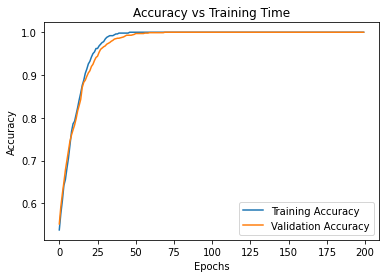

Text(0.5, 1.0, 'Loss vs Training Time')

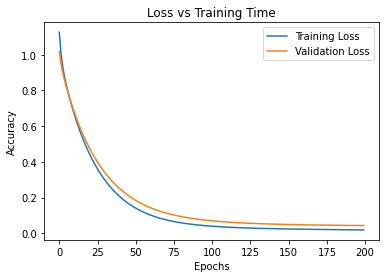

In [8]:
# The below code visualizes the evolution of accuracy and loss curves throughout
# the training process.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Training Time')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Loss vs Training Time')

### Exercise 2

In the above simulation we have observed that a two-layer ReLU network trained by gradient descent learns the correct parity function $f_{S}$ when the support set is $S=\{0\}$. Repeat the above experiment with parity functions supported on larger sets (e.g., $S=\{0,1\}; S=\{0,1,\dots,d-1\}$; $S$ sampled uniformly at random). For what sizes of $S$ do you observe that the problem gets difficult? Explore the above experimental setup by:

- modifying the neural network architecture (e.g., adding more layers, increasing/decreasing the hidden dimension, changing the activation function, etc);
- modifying the optimization algorithm and its hyper-parameters;
- modifying the dataset size and input dimension parameters.

You may find it helpful to refer to Keras documentation available in the following link https://www.tensorflow.org/api_docs/python/tf/keras.

#### Solution

Exploring the above exercise you should have concluded that for large enough support sets $S$ (e.g., $|S|=20$) learning the true parity function becomes difficult regardless of the neural network architecture, choice of the optimizer, its hyper-parameters and other parameters of the problem.


## Is Learning Parity Functions Hard?

In exercise 2, we have empirically concluded that learning parity functions
is a difficult learning problem for neural networks trained by gradient descent.
<font color='green'>**At this point, it is not clear if learning parities is possible for any algorithm, from either statistical or computational perspective.**</font> An open possibility remains that the problem of learning parities is difficult for any learning algorithm, and perhaps we have not observed anything special in the failure of neural networks trained by gradient descent. This section investigates whether learning parity functions is hard from a statistical perspective (Exercise 3) and whether it is hard from a computational perspective (Exercise 4).

### Exercise 3

Argue why from an information-theoretic perspective, the problem of learning parity functions is not difficult. To do so, suggest a procedure that correctly learns the true parity function, disregarding any computational constraints (i.e., your algorithm is allowed to run in exponential time).

#### Hint

There is a finite number of parity functions and the generated labels contain zero noise.

#### Solution

Let $P$ denote the data generating distribution (i.e., the data points $(x_{i}, y_{i})$ are sampled i.i.d. from $P$). For a function $f : \mathcal{X} \to \{-1, +1\}$ denote its error as
$$
  \operatorname{err}(f) = \mathbb{P}_{(x,y) \sim P}\left( f(x) \neq y\right)
$$


For any function $f$, probability that it is consistent with the training data (i.e., correctly labels each of the data points) is at most
$$
  \mathbb{P}\left(f \text{ is consistent with the training data }(X, y) \right)
  = (1 - \operatorname{err}(f))^{n}
  \leq e^{-n \operatorname{err}(f)},
$$
where $n$ is the number of data points.


Let $\mathcal{A} = \{ f_{S} : S \subseteq \{0, \dots, d-1\}\}$ denote the set of all parity functions. Fix any $\varepsilon > 0$ and let $\mathcal{A}_{\mathrm{bad}} \subseteq \mathcal{A}$ denote the subset of parity functions whose error is at least $\varepsilon$. It follows via the union bound that
$$
  \mathbb{P}\left( \text{exists } f \in \mathcal{A}_{\mathrm{bad}} \text{ that is consistent with the training data (X, y) }
    \right)
    \leq |\mathcal{A}_{\mathrm{bad}}|e^{-n\varepsilon}
    \leq 2^{d}e^{-n \varepsilon}.
$$
For any $\delta \in (0,1)$, the above probability is at most $\delta$ provided that $n \geq \frac{d\log(2) + \log(\delta^{-1})}{\varepsilon}$.

<font color='green'>**In particular, the above argument establishes that for large enough sample sizes  N, it is enough to output any parity function that correctly labels the training data. Since there is a finite number of such functions, we can try all of them and return any parity function consistent with the training data. Such a parity function is guaranteed to exist since the training data is labeled by one such function.**</font>

### Exercise 4

In Exercise 3, we have shown that the noise-free problem of learning parity functions is easy from an information-theoretic perspective; however, to do so we have provided an algorithm that requires exponential computational resources. This leaves an open possibility that no polynomial time algorithm can identify the correct parity function.

In this exercise, you are asked to find a polynomial-time algorithm that learns the correct parity function, provided that the training data set is large enough (e.g., $n \geq d$).

In [9]:
def learn_the_correct_parity(X, y):
  """ :X: A matrix in {-1, +1}^{n \times d} of covariate vectors.
      :y: A vector in {-1, +1}^{n} generated by some parity function f_{S}
          applied to the rows of $X$.
      :returns: A support set $S$ of the parity function f_{S} that generated
          the labels.
  """
  ##############################################################################
  # Exercise 4. Implement a polynomial time algorithm that learns the true
  # partity function.

  # First convert the data so that the elements of X,y are in {0,1} and we 
  # have y = Xw_{S} (where w_S represents the true parity function) and the
  # addition is performed modulo 2.
  X = (X - 1.0)/(-2.0) # -1 becomes 1, 1 becomes 0.
  y = (y - 1.0)/(-2.0) # same as above.
  X = X.astype(int)
  y = y.astype(int)
  # We will now implement Gaussian elimination to find the solution.
  d = X.shape[1]
  y = y.reshape(-1, 1)


  def switch_rows(X, y, i, j):
    """ Switches the i-th and j-th row in the matrix X and a vectory y (viewed
    as an (n \times 1) matrix. """
    X[[i,j],:] = X[[j,i],:]
    y[[i,j],0] = y[[j,i],0]

  for i in range(d):
    # Switch some rows to make X[i,i]=1
    if np.alltrue(X[i:, i] == 0):
      # Skip this column, as all elements are equal to 0 below the i-th row.
      continue
    non_zero_idx = np.argmin(X[i:,i] == 0)+i
    switch_rows(X, y, i, non_zero_idx)
    # Right now we have X[i,i] = 1.0
    # Perform all the row reduction operations for the i-th column, to make
    # X[j,i] = 0 for all j not equal to i.
    mask = X[:,i].copy().reshape(-1, 1)
    mask[i,0] = 0 # Do not add the i-th row to itselt.
    X += mask @ X[i,:].reshape(1, -1) # Perform the row operations on X
    X %= 2
    y += y[i,0] * mask # Perform the row operations on y
    y %= 2
  
  S = []
  for i in range(d):
    if X[i,i] == 1 and y[i,0] == 1:
      S.append(i)
  return np.array(S)
  ##############################################################################


# The below code tests our implementation.
np.random.seed(0)
d = 100
S = np.random.choice(d, size = 10, replace=False)
X = generate_uniform_covariates(n=d, d=d)
print(X)
print()
y = ParityFunction(S=S)(X)
print("True S =\n", np.sort(S))
computed_S = learn_the_correct_parity(X, y)
print("Computed S =\n", computed_S)
print("Consistent output:", np.allclose(y, ParityFunction(computed_S)(X)))

[[-1.  1. -1. ... -1. -1.  1.]
 [-1.  1. -1. ... -1.  1. -1.]
 [-1.  1.  1. ...  1. -1.  1.]
 ...
 [ 1. -1.  1. ...  1. -1.  1.]
 [-1.  1. -1. ... -1. -1.  1.]
 [ 1. -1.  1. ... -1.  1. -1.]]

True S =
 [ 2 16 26 54 55 73 75 86 93 95]
Computed S =
 [ 2 16 26 54 55 73 75 86 93 95]
Consistent output: True


#### Hint

Relabel $+1 \mapsto 0$ and $-1 \mapsto 1$ and think of parity functions as addition modulo 2 on $\{0, 1\}^{d}$.

#### Solution

<font color='green'>**The key observation is that the problem we are trying to solve is just a linear system of equations over the finite field $\text{GF}(2)$.**</font>
Hence, we can recover the true parity function by simply solving the linear system (e.g., by performing Gaussian elimination). A sample implementation is provided below.

```
  # First convert the data so that the elements of X,y are in {0,1} and we 
  # have y = Xw_{S} (where w_S represents the true parity function) and the
  # addition is performed modulo 2.
  X = (X - 1.0)/(-2.0) # -1 becomes 1, 1 becomes 0.
  y = (y - 1.0)/(-2.0) # same as above.
  X = X.astype(int)
  y = y.astype(int)
  # We will now implement Gaussian elimination to find the solution.
  d = X.shape[1]
  y = y.reshape(-1, 1)


  def switch_rows(X, y, i, j):
    """ Switches the i-th and j-th row in the matrix X and a vectory y (viewed
    as an (n \times 1) matrix. """
    X[[i,j],:] = X[[j,i],:]
    y[[i,j],0] = y[[j,i],0]

  for i in range(d):
    # Switch some rows to make X[i,i]=1
    if np.alltrue(X[i:, i] == 0):
      # Skip this column, as all elements are equal to 0 below the i-th row.
      continue
    non_zero_idx = np.argmin(X[i:,i] == 0)+i
    switch_rows(X, y, i, non_zero_idx)
    # Right now we have X[i,i] = 1.0
    # Perform all the row reduction operations for the i-th column, to make
    # X[j,i] = 0 for all j not equal to i.
    mask = X[:,i].copy().reshape(-1, 1)
    mask[i,0] = 0 # Do not add the i-th row to itselt.
    X += mask @ X[i,:].reshape(1, -1) # Perform the row operations on X
    X %= 2
    y += y[i,0] * mask # Perform the row operations on y
    y %= 2
  
  S = []
  for i in range(d):
    if X[i,i] == 1 and y[i,0] == 1:
      S.append(i)
  return np.array(S)
```

## Understanding Why Neural Networks Fail

One possible reason for failure to learn the correct parity function in our neural network experiments is that our chosen architecture was not expressive enough to contain the target parity functions. The below exercise asks us to rule out this possibility.

### Exercise 5


Complete the below code cell, which asks to find a configuration of ReLU network weights that realize *exactly* a given parity function $f_{S}$.

In [10]:
# Fill in the missing code in the following function.
def get_parity_relu_network(d, S):
  """
  :d: The input dimension.
  :S: An array specifying the indexes in {0, 1, ..., d-1} of the parity function
      to be implemented by this function.
  
  :returns: A relu network with one hidden layer that implements the parity
  function indexed by S.
  """

  ##############################################################################
  # Exercise 5.1. Set the hidden layer dimension required by your construction.
  S = np.array(S)
  hidden_d = len(S)+1 # The hidden layer dimension of your construction. 
  ##############################################################################

  # Create a relu network with the specified dimensions.
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(d,)),
    tf.keras.layers.Dense(hidden_d, activation='relu'),
    tf.keras.layers.Dense(1, activation=None),
  ])

  # Convert model parameters to numpy arrays.
  W1, b1 = model.layers[0].get_weights()
  W1 = np.array(W1).transpose()
  b1 = np.array(b1)
  W2, b2 = model.layers[1].get_weights()
  W2 = np.array(W2).transpose()
  b2 = np.array(b2)

  # Recall that the above relu network implements the function
  # x \in \R^{d} --> (W2) relu((W1) x + b1) + b2.
  
  ##############################################################################
  # Exercise 5.2. Your code for setting W1, b1, W2, b2 goes below.
  W1 *= 0
  b1 *= 0
  W2 *= 0
  b2 *= 0
 
  # Set the weights of the first layer.
  W1[:-1, S] = -1/2
  b1[:-1] = len(S)/2 - np.arange(len(S))
  W1[-1, S] = -1/4
  b1[-1] = len(S)/4
 
  # We now turn to the weights of the second layer.
  W2[:] = 1
  W2[0, ::2] = -1
  W2[0, -1] = 1
  W2 *= 4
  b2[:] = 1
  ##############################################################################

  # Set the model parameters with the above implemented construction.
  model.layers[0].set_weights([W1.transpose(), b1])
  model.layers[1].set_weights([W2.transpose(), b2])

  return model


# The below code verifies if the implemented "get_parity_relu_network" function
# agrees with the data generated via the ParitiesData class implemented earlier.
d = 100
# Sample a random support set S for the parity function f_S.
coin_flips = np.random.binomial(n=1, p=0.5, size=d)
S = np.arange(d)[coin_flips >= 1]
f_S = ParityFunction(S=S)
X = generate_uniform_covariates(n=2*d, d=d)
y = f_S(X)

parity_network = get_parity_relu_network(d, S)
y_pred = np.array(parity_network(X)).flatten()

# Check if the y_pred vector equals element-wise to the vector y.
assert (y_pred == y).all()
print("Assertion passed.")

Assertion passed.


#### Solution

It is enough to set the hidden unit dimension to |S| + 1.
```
# Exercise 5.1.

S = np.array(S)
hidden_d = len(S)+1 # The hidden layer dimension of your construction. 
```
Without loss of generality, assume that $S = \{0, 1, \dots, d-1\}$, since otherwise the coordinates outside of the support set $S$ can be ignored. Suppose that an input vector $x \in \{-1, +1\}^{d}$ contains $u$ entries equal to $+1$ and $v$ entries equal to $-1$. Hence, we have $u + v = d$.
The output of the parity function $f_{S}$ is then equal to $+1$ if $v$ is even and $-1$ if $v$ is odd. Letting $\mathbf{1} \in \mathbb{R}^{d}$ denote the vector of ones, we have $\langle \mathbf{1}, x \rangle = u - v$. Therefore, we also have $\langle \mathbf{1}, x \rangle = d - 2v$.

**Setting the weights of the first layer.**

Notice that if we set the first $d$ hidden units to $-\frac{1}{2} \mathbf{1}$, and if we set the first $d$ bias terms to $d_{i} = \frac{d}{2} - i$ (with indexing starting from $0$), then the value computed by the $i$-th hidden unit is equal to $(W_{1}x)_{i} + b_{i} = v - i$. Finally, set the last, $d+1$-th hidden unit (i.e., the last row of the matrix $W_1$) to $-\frac{1}{4}\mathbf{1}$ and set the last bias term to $\frac{d}{4}$. This results in the $d+1$-th activation equal to $\frac{v}{2}$.

**Setting the weights of the second layer.**
The input received by the second layer is equal to
$$
  \left(\text{ReLU}(v), \text{ReLu}(v-1), \text{ReLu}(v-2), \dots, \text{ReLu}(v-d+1), \frac{v}{2}\right)^{\mathsf{T}}.
$$
Setting the bias term $b_{2} = 1$ and the layer weights to the alternating pattern $-4, +4, -4, +4, \dots$ realizes the desired parity function.


Sample implementation of the above-described solution is provided below.
```
  # Exercise 5.2.

  W1 *= 0
  b1 *= 0
  W2 *= 0
  b2 *= 0
  
  # Set the weights of the first layer.
  W1[:-1, S] = -1/2
  b1[:-1] = len(S)/2 - np.arange(len(S))
  W1[-1, S] = -1/4
  b1[-1] = len(S)/4

  # We now turn to the weights of the second layer.
  W2[:] = 1
  W2[0, ::2] = -1
  W2[0, -1] = 1
  W2 *= 4.
  b2[:] = 1
```

### Intuitive Reasons for Failure to Learn the True Parity

Let us summarize what we have discussed up to this point:
- we found it challenging to learn the true parity function by training various architectures of neural networks;
- we understood that the problem of learning parity functions is not hard from the statistical perspective;
- we also understood that the problem is not difficult from a computational perspective;
- we have also found that ReLU neural networks are expressive enough to realize parity functions with reasonably small weights.

So why do the gradient methods fail to find the correct configuration of model weights? <font color='green'>**It turns out that this problem has nothing to do with neural networks; rather, it is known to be difficult (from a computational perspective) for a large class of algorithms known as statistical query algorithms.**</font> Such algorithms are, informally, procedures that do not inspect the individual data points but are instead based on some aggregate statistics of the observed data. Gradient descent can be shown to fall into this category (see the bibliographic remarks section).

Let us now sketch the argument showing why gradient methods find it challenging to solve the parities problem. Let $\mathcal{A} = \{ a_{w} : \{0,1\}^{d} \to \mathbb{R} \mid w \in \mathbb{R}^{m}\}$ denote some class of parametric functions (such as neural networks considered above). Let $P_{S}$ denote the data generating distribution assuming that the true parity function is given by $f_{S}$ and as before, the covariates are sampled uniformly from the boolean hypercube. Let
$$
  r_{S}(a_w) = \mathbf{E}_{(X,Y) \sim P_{S}}[(a_w(X) - Y)^{2}]
  = \mathbf{E}_{(X,Y) \sim P_{S}}[(a_w(X) - f_{S}(X))^{2}].
$$
Let $R_{S}$ denote the empirical risk function for a dataset of size $n$ sampled from the distribution $P_S$.
When the dataset size $n$ is large enough, for any fixed point $w \in \mathbb{R}^{m}$ we have $\nabla_{w} R_{S}(a_w) \approx \nabla_{w} r_{S}(a_w)$. <font color='green'>**We will now attempt to quantify the amount of information contained in the true gradient $\nabla_{w} r_{S}(a_w)$.**</font>
In order to do that, we will try to upper bound the variance of the gradient at an arbitrary point $w$, with the randomness coming from sampling $S$ uniformly over all possible subsets of $\{0, 1, \dots, d-1\}$:
$$
  \mathrm{Var}(\nabla r, w)
  = \mathbf{E}_{S \sim \text{Uniform}} \| \nabla_{w} r_{S}(w) - \mathbf{E}_{S' \sim \text{Uniform}}[\nabla_{w} r_{S'}(w)]\|_{2}^{2}.
$$
<font color='green'>**If the above quantity is small, it means that the gradient
$\nabla_{w} r_{S}(w)$ does not depend too much on $S$, and hence the gradient does not depend on the signal.**</font> We will now proceed to show that the below quantity is indeed exponentially small in the dimension $d$.

First, notice that
$$
  \nabla_{w}r_{S}(w) = \mathbf{E}_{(X,Y)\sim P_{S}}[\nabla_{w} (a_w(X) - f_{S}(X))]
  = \mathbf{E}_{X}[2\nabla_{w}a_{w}(X)(a_{w}(X) - f_{S}(X))].
$$
We hence have
\begin{align*}
  \frac{1}{4}\mathrm{Var}(\nabla r, w)
  &= \frac{1}{4}\mathbf{E}_{S} \| \nabla_{w} r_{S}(w) - \mathbf{E}_{S'}[
    \nabla_{w} r_{S'}(w)]\|_{2}^{2}
  \\
  &\leq \frac{1}{4}\mathbf{E}_{S} \| \nabla_{w} r_{S}(w) -
  2\mathbf{E}_{X}[\nabla_{w}a_{w}(X)a_{w}(X)] \|_{2}^{2}
  \\
  &= \mathbf{E}_{S} \|\, \mathbf{E}_{X}[\nabla_{w}a_{w}(X)f_{S}(X)]\, \|_{2}^{2}.
\end{align*}
To simplify the notation, let us now write $g(X) = \nabla_{w}a_{w}(X)$.
Further, let $\langle f, g \rangle_{P_{X}} = \mathbf{E}_{X}[f(X)g(X)]$, where $X$ is distributed uniformly over the boolean hypercube. Using the fact that the $2^{d}$ parity functions form a basis over the Hilbert space $L_{2}(P_{X})$ of real-valued functions with the domain $\{-1,1\}^{d}$, we have
\begin{align*}
  \mathbf{E}_{S} \sum_{i=1}^{m}\left(
    \mathbf{E}_{X}[g_{i}(X)f_{S}(X)]
    \right)^{2} 
  &= \mathbf{E}_{S} \sum_{i=1}^{m}\langle g_{i}, f_{S} \rangle^{2}_{P_{X}} \\
  &= \frac{1}{2^{d}} \sum_{S}\sum_{i=1}^{m}\langle g_{i}, f_{S} \rangle^{2}_{P_{X}} \\
  &= \frac{1}{2^{d}} \sum_{i=1}^{m} \sum_{S} \langle g_{i}, f_{S} \rangle^{2}_{P_{X}} \\
  &= \frac{1}{2^{d}} \sum_{i=1}^{m} \|g_{i}\|_{P_{X}}^{2} \\
  &= \frac{1}{2^{d}} \mathbf{E}_{X}[\|g(X)\|_{2}^{2}].
\end{align*}
To sum up the above derivations, we have shown that
$$
  \mathrm{Var}(\nabla r, w) \leq \frac{\mathbf{E}_{X}[\|g(X)\|_{2}^{2}]}
  {2^{d-2}}.
$$
<font color='green'>**In particular, the variance of the gradient with respect to uniform draw of a target parity function is exponentially small in the dimension $d$. This establishes that gradients for the parity problem are strongly concentrated in directions independent of the true signal.**</font>

## Bibliographic Remarks

The study of learning theory from the computational complexity theory point of view was pioneered by *Valiant [1984]*, where the so-called PAC learning framework was introduced. Various tweaks of the PAC learning models were subsequently studied. One such model motivated by the need to develop noise-tolerant learning algorithms, called the statistical
query model, was introduced by *Kearns [1998]*, where it was also shown that the problem of learning parity functions cannot be solved using a polynomial number of queries; see also the textbook by *Kearns, Vazirani, and Vazirani [1994]*. Whether there exists an algorithm that can learn the underlying parity function in the presence of label noise is a long-standing
open problem; see *Blum, Kalai, and Wasserman [2003]*. This practical session is based on Section 2 of *Shalev-Shwartz, Shamir, and Shammah [2017]*, where other limitations of gradient-based learning are also presented. Most of the learning algorithms used in practice can be implemented using statistical queries. For further background reading, see the discussions and references in the papers by *Feldman, Grigorescu, Reyzin, Vempala, and Xiao [2017]*, *Feldman [2017]*.

**References**

A. Blum, A. Kalai, and H. Wasserman. Noise-tolerant learning, the parity problem, and the statistical query model. Journal of the ACM (JACM), 50(4):506–519, 2003.

V. Feldman. A general characterization of the statistical query complexity. In Conference on Learning Theory, pages 785–830. PMLR, 2017.

V. Feldman, E. Grigorescu, L. Reyzin, S. S. Vempala, and Y. Xiao. Statistical algorithms and a lower bound for detecting planted cliques. Journal of the ACM (JACM), 64(2): 1–37, 2017.

M. Kearns. Efficient noise-tolerant learning from statistical queries. Journal of the ACM (JACM), 45(6):983–1006, 1998.

M. J. Kearns, U. V. Vazirani, and U. Vazirani. An introduction to computational learning theory. MIT press, 1994.

S. Shalev-Shwartz, O. Shamir, and S. Shammah. Failures of gradient-based deep learning. In International Conference on Machine Learning, pages 3067–3075. PMLR, 2017.

L. G. Valiant. A theory of the learnable. Communications of the ACM, 27(11):1134–1142, 1984.